In [4]:
import gpflow as gp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gp_package.VSHGP import VSHGP

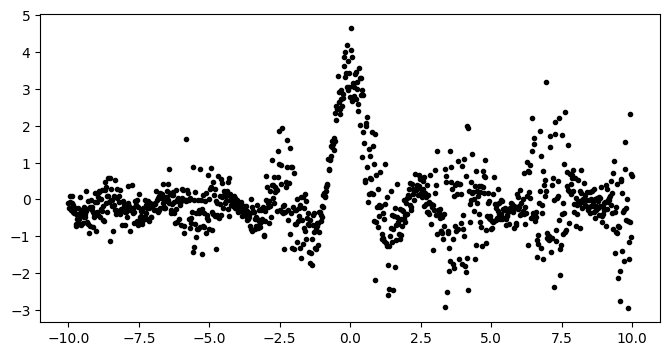

In [2]:
# generate some synthetic data
np.random.seed(42)

n = 1000 # number of samples

X  = np.reshape(np.linspace(-10, 10, num = n), (-1, 1))
SX = 0.05 + (1.0 / (1 + np.exp(-0.2 * X))) * (1 + np.sin(2 * X)) * 0.2   

Y = np.sinc(X) + np.random.randn(X.shape[0], X.shape[1]) * SX
Xs = np.reshape(np.linspace(-10, 10, num = n), (-1, 1))

# normalize Y to zero mean and unit variance
Ynorm = (Y - Y.mean()) / Y.std()

# plot the training data
plt.figure(figsize = (8, 4))
plt.plot(Xs, Ynorm, 'k.')

In [5]:
kernel_f = gp.kernels.SquaredExponential()
kernel_g = gp.kernels.SquaredExponential()
# how many inducing points?
M = 50

F = np.linspace(X.min(), X.max(), M)[:, None] # inducing points for the mean GP
G = np.linspace(X.min(), X.max(), M)[:, None] # inducing points for the log-var GP

inducing_f = gp.inducing_variables.InducingPoints(F)
inducing_g = gp.inducing_variables.InducingPoints(G)

model = VSHGP(data= (X, Ynorm), kernel_f=kernel_f, kernel_g =kernel_g, inducing_points_f= inducing_f, inducing_points_g= inducing_g)

gp.utilities.print_summary(model)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═══════════╤═════════╤═══════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape     │ dtype   │ value     │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═══════════╪═════════╪═══════════╡
│ VSHGP.Kf.variance     │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 1.0       │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼───────────┤
│ VSHGP.Kf.lengthscales │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 1.0       │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼───────────┤
│ VSHGP.Kg.variance     │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 1.0       │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼───────────┤
│ VSHGP.Kg

In [36]:
params = dict()
params['no_steps'] = 1000
params['log_interval']= 1
params['learning_rate'] = 0.0001 # start with a small learning rate

# Note: initially we set the inducing points to be non-trainable
gp.utilities.set_trainable(model.inducing_f, True)
gp.utilities.set_trainable(model.inducing_g, True)

model.fit(params, compile=True) 

# look at the model summary
gp.utilities.print_summary(model)

100%|██████████| 1000/1000 [02:12<00:00,  7.53it/s, loss=439]

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═══════════╤═════════╤═══════════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape     │ dtype   │ value         │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═══════════╪═════════╪═══════════════╡
│ VSHGP.Kf.variance     │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 1.00002       │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼───────────────┤
│ VSHGP.Kf.lengthscales │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 0.76538       │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼───────────────┤
│ VSHGP.Kg.variance     │ Parameter │ Softplus    │         │ True        │ ()        │ float64 │ 1.472         │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─

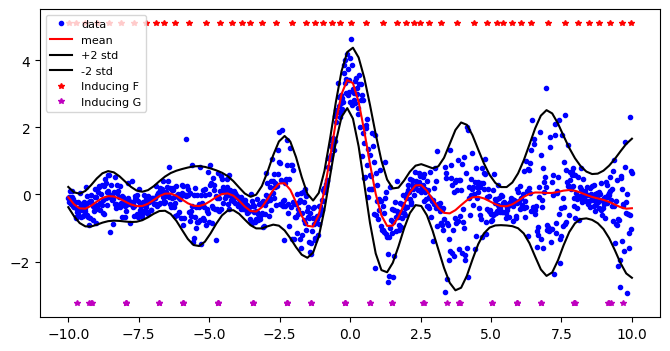

In [38]:
# plot the results

xtest = np.linspace(-10, 10 , 100)[:, None]
mean, var = model.predict_f(xtest)

plt.figure(figsize = (8,4))
plt.plot(X, Ynorm, 'b.', label = 'data')
plt.plot(xtest, mean, 'r-', label = 'mean')
plt.plot(xtest, mean + 1.96 * np.sqrt(var), 'k-', label = '+2 std')
plt.plot(xtest, mean - 1.96 * np.sqrt(var), 'k-', label = '-2 std')
plt.plot(model.inducing_f.Z.numpy(), Ynorm.max() * 1.1 * np.ones_like(F), 'r*', markersize = 4, label = 'Inducing F')
plt.plot(model.inducing_g.Z.numpy(), Ynorm.min() * 1.1 * np.ones_like(G), 'm*', markersize = 4, label = 'Inducing G')
plt.legend(fontsize = 8, loc = 'upper left')